In [ ]:
!nvidia-smi

Fri Apr  4 01:55:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

In [ ]:
!pip install -q "git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/CLIP"
!pip install -q "git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/ml-mobileclip"
!pip install -q "git+https://github.com/THU-MIG/yoloe.git#subdirectory=third_party/lvis-api"
!pip install -q "git+https://github.com/THU-MIG/yoloe.git"

!pip install -q supervision jupyter_bbox_widget

!wget -q https://docs-assets.developer.apple.com/ml-research/datasets/mobileclip/mobileclip_blt.pt

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Pull weights

In [ ]:
from huggingface_hub import hf_hub_download

path = hf_hub_download(repo_id="jameslahm/yoloe", filename="yoloe-v8l-seg.pt", local_dir='.')
path = hf_hub_download(repo_id="jameslahm/yoloe", filename="yoloe-v8l-seg-pf.pt", local_dir='.')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


yoloe-v8l-seg.pt:   0%|          | 0.00/107M [00:00<?, ?B/s]

yoloe-v8l-seg-pf.pt:   0%|          | 0.00/103M [00:00<?, ?B/s]

## Text prompt for image processiong

Build text model mobileclip:blt


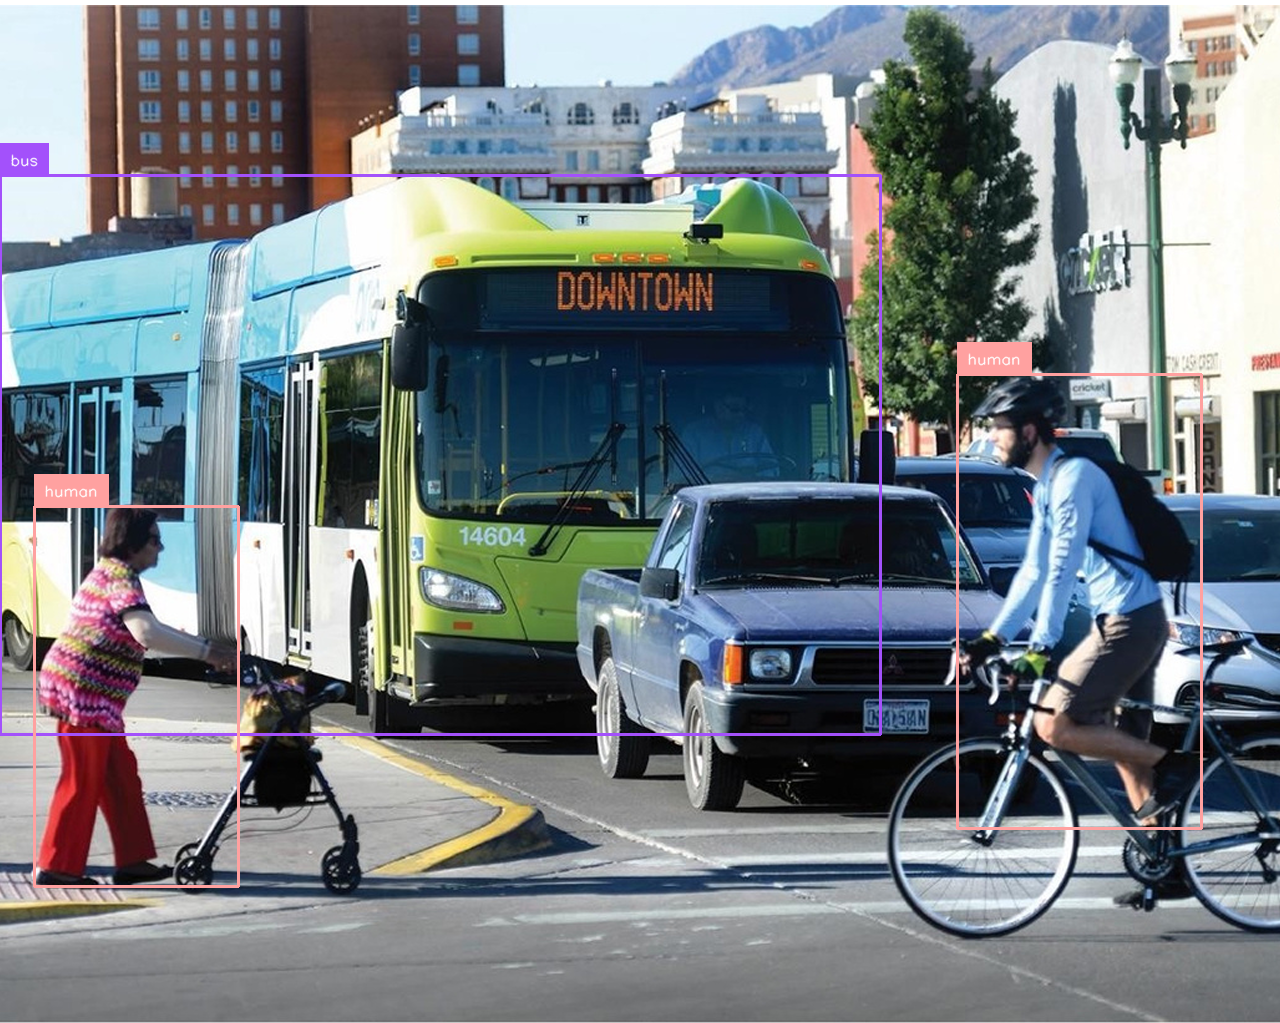

In [ ]:
import supervision as sv
from ultralytics import YOLOE
from PIL import Image

IMAGE_PATH = "/content/TEST.png"
NAMES = ["bus","motor-cycle","human"]

model = YOLOE("yoloe-v8l-seg.pt").cuda()
model.set_classes(NAMES, model.get_text_pe(NAMES))

image = Image.open(IMAGE_PATH)
results = model.predict(image, conf=0.1, verbose=False)

detections = sv.Detections.from_ultralytics(results[0])

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator().annotate(scene=annotated_image, detections=detections)
annotated_image = sv.LabelAnnotator().annotate(scene=annotated_image, detections=detections)

annotated_image

Build text model mobileclip:blt


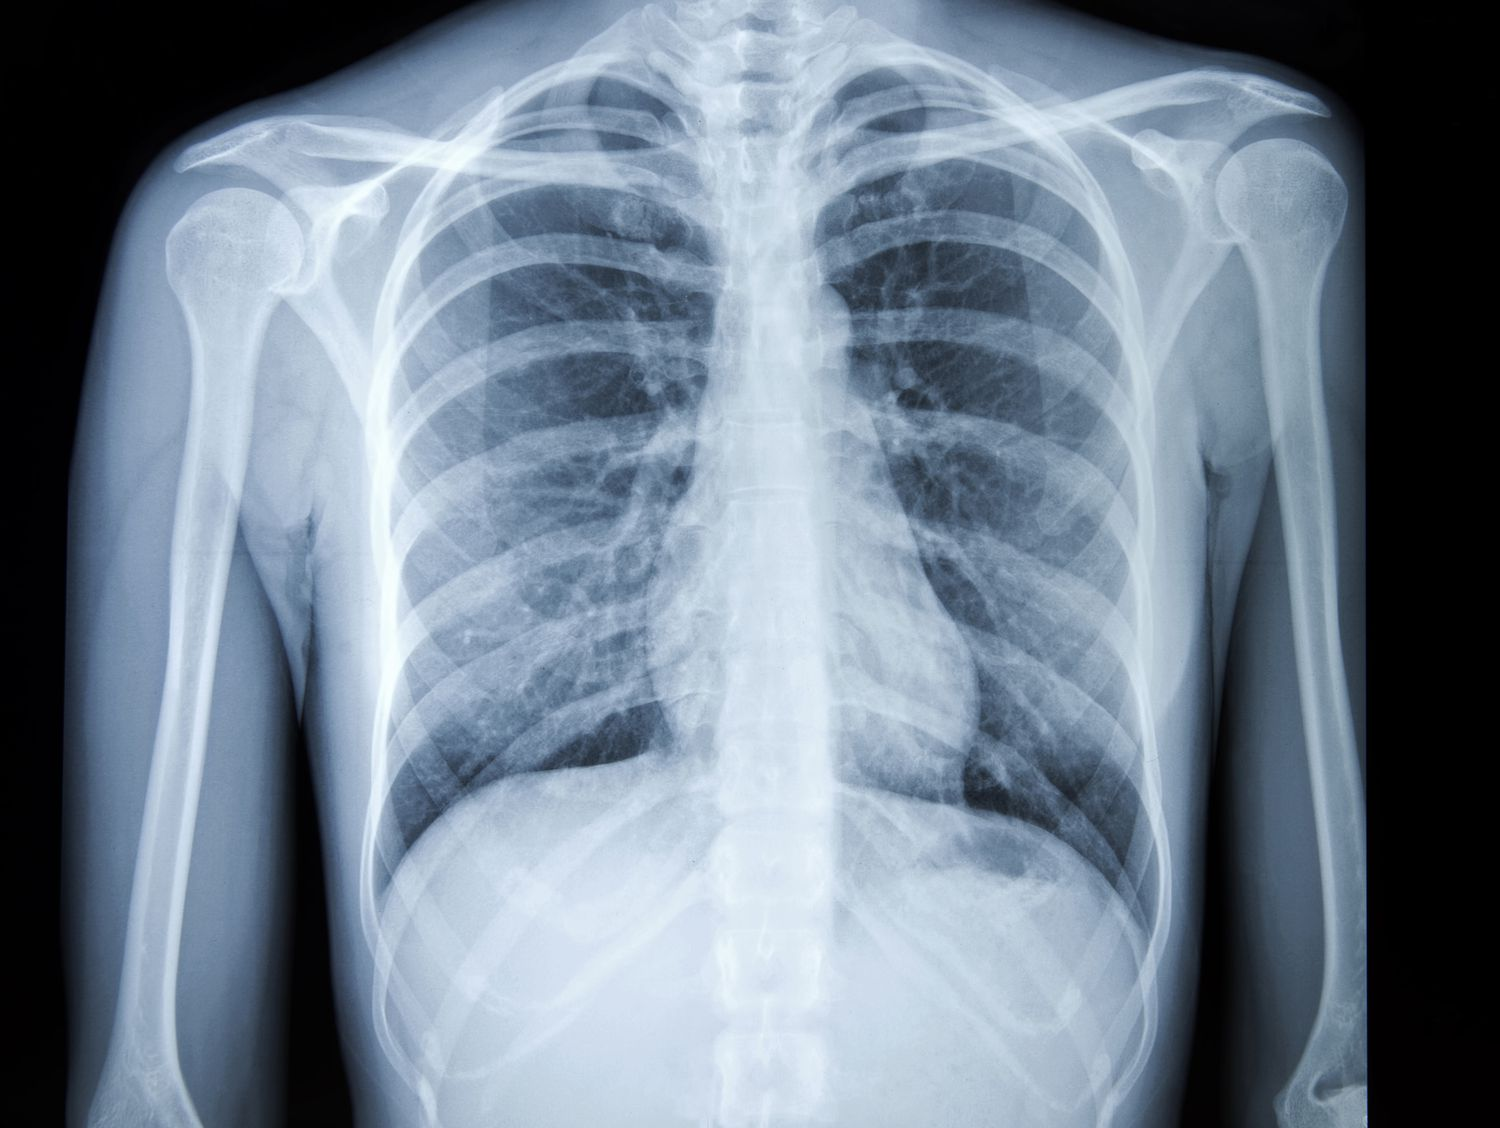

In [ ]:
import supervision as sv
from ultralytics import YOLOE
from PIL import Image

IMAGE_PATH = "/content/chest_xray.jpg"
NAMES = ["lungs","ribs"]

model = YOLOE("yoloe-v8l-seg.pt").cuda()
model.set_classes(NAMES, model.get_text_pe(NAMES))

image = Image.open(IMAGE_PATH)
results = model.predict(image, conf=0.1, verbose=False)
detections = sv.Detections.from_ultralytics(results[0])

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator().annotate(scene=annotated_image, detections=detections)
annotated_image = sv.LabelAnnotator().annotate(scene=annotated_image, detections=detections)

annotated_image

## Visual prompt for image processiong

In [ ]:
import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to **draw bounding box** on the image 👇

In [ ]:
IS_COLAB = True
SOURCE_IMAGE_PATH = "/content/TEST.png"
TARGET_IMAGE_PATH = "/content/test_3.jpg"
NAMES = ["truck","human","sign","signal"]

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget(classes=NAMES)
widget.image = encode_image(SOURCE_IMAGE_PATH)
widget

BBoxWidget(classes=['truck', 'human', 'sign', 'signal'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '…

In [ ]:
widget.bboxes

[{'x': 534, 'y': 461, 'width': 491, 'height': 318, 'label': 'truck'},
 {'x': 26, 'y': 473, 'width': 349, 'height': 496, 'label': 'human'},
 {'x': 930, 'y': 391, 'width': 319, 'height': 574, 'label': 'human'},
 {'x': 1043, 'y': 238, 'width': 90, 'height': 62, 'label': 'sign'}]

**NOTE:** `YOLOEVPSegPredictor` takes `np.ndarray` box prompt in `[x_min, y_min, x_max, y_max]` format.


0: 640x640 4 object0s, 1 object1, 148.4ms
Speed: 5.1ms preprocess, 148.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 50.8ms
Speed: 2.9ms preprocess, 50.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


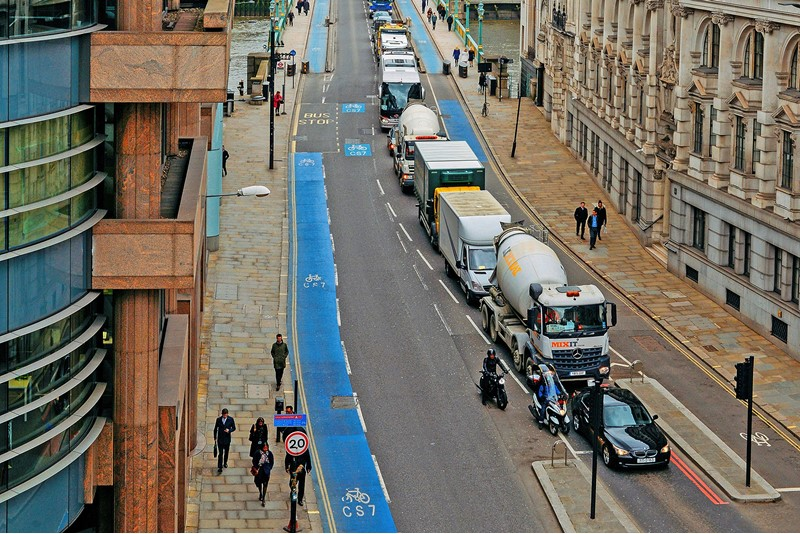

In [ ]:
from ultralytics import YOLOE
from ultralytics.models.yolo.yoloe.predict_vp import YOLOEVPSegPredictor

model = YOLOE("yoloe-v8l-seg.pt").cuda()
prompts = dict(bboxes=bboxes, cls=cls)

source_image = Image.open(SOURCE_IMAGE_PATH)
target_image = Image.open(TARGET_IMAGE_PATH)

model.predict(source_image, prompts=prompts, predictor=YOLOEVPSegPredictor, return_vpe=True)
model.set_classes(NAMES, model.predictor.vpe)
model.predictor = None

results = model.predict(target_image)
detections = sv.Detections.from_ultralytics(results[0])

annotated_image = target_image.copy()
annotated_image = sv.BoxAnnotator().annotate(scene=annotated_image, detections=detections)
annotated_image = sv.LabelAnnotator().annotate(scene=annotated_image, detections=detections)

annotated_image